In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
import gc
from scipy import sparse
%matplotlib inline

In [2]:
df_train = pd.read_csv('data/sales_train.csv.gz', compression='gzip')
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
df_date = df_train[['date', 'date_block_num']]
df_date.drop_duplicates('date_block_num', inplace=True)
df_date['date_formatted'] = pd.to_datetime(df_date.date, format="%d.%m.%Y")
df_date[['day','month','year']] = df_date.date.str.split('.',expand=True)
df_date['date_month'] = (df_date.year + df_date.month).astype(str)
df_date = df_date[['date_block_num','date_month', 'month','year']]
df_date

/home/liaojiping/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/liaojiping/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/liaojiping/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,date_block_num,date_month,month,year
0,0,201301,01,2013
115690,1,201302,02,2013
224303,2,201303,03,2013
345650,3,201304,04,2013
439759,4,201305,05,2013
531518,5,201306,06,2013
631921,6,201307,07,2013
732469,7,201308,08,2013
837241,8,201309,09,2013
933378,9,201310,10,2013


In [4]:
df_test = pd.read_csv('data/test.csv.gz', compression='gzip')
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
df_item_bigcat = pd.read_csv('data/item_categories.csv')
l = list(df_item_bigcat.item_category_name)
l_cat = l
for ind in range(1,8): l_cat[ind] = 'Access'
for ind in range(10,18): l_cat[ind] = 'Consoles'
for ind in range(18,25): l_cat[ind] = 'Consoles Games'
for ind in range(26,28): l_cat[ind] = 'phone games'
for ind in range(28,32): l_cat[ind] = 'CD games'
for ind in range(32,37): l_cat[ind] = 'Card'
for ind in range(37,43): l_cat[ind] = 'Movie'
for ind in range(43,55): l_cat[ind] = 'Books'
for ind in range(55,61): l_cat[ind] = 'Music'
for ind in range(61,73): l_cat[ind] = 'Gifts'
for ind in range(73,79): l_cat[ind] = 'Soft'
df_item_bigcat['bigcat'] = l_cat
df_item_bigcat

,item_category_name,item_category_id,bigcat
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access
5,Аксессуары - PSVita,5,Access
6,Аксессуары - XBOX 360,6,Access
7,Аксессуары - XBOX ONE,7,Access
8,Билеты (Цифра),8,Билеты (Цифра)
9,Доставка товара,9,Доставка товара


In [6]:
df_items = pd.read_csv('data/items.csv')
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
df_item_bigcat = df_item_bigcat.merge(df_items)
df_item_bigcat.drop(['item_category_name', 'item_name'], axis=1, inplace=True)
df_item_bigcat.head()

,item_category_id,bigcat,item_id
0,0,PC - Гарнитуры/Наушники,5441
1,0,PC - Гарнитуры/Наушники,16255
2,0,PC - Гарнитуры/Наушники,16256
3,0,PC - Гарнитуры/Наушники,16257
4,1,Access,5606


In [8]:
df_train = df_train.merge(df_item_bigcat, 'left')
# df_train.loc[:, 'item_category_id'] = df_train.loc[:, 'item_category_id'].fillna(-1).astype(int)
print(df_train.shape)
df_train.head()

(2935849, 8)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,bigcat
0,02.01.2013,0,59,22154,999.00,1.0,37,Movie
1,03.01.2013,0,25,2552,899.00,1.0,58,Music
2,05.01.2013,0,25,2552,899.00,-1.0,58,Music
3,06.01.2013,0,25,2554,1709.05,1.0,58,Music
4,15.01.2013,0,25,2555,1099.00,1.0,56,Music


In [9]:
# Encode Categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df_train[['bigcat']] = number.fit_transform(df_train.bigcat)
df_item_bigcat[['bigcat']] = number.transform(df_item_bigcat.bigcat)

In [10]:
df_test = df_test.merge(df_item_bigcat, 'left')
# df_test.loc[:, 'item_category_id'] = df_test.loc[:, 'item_category_id'].fillna(-1).astype(int)
df_test.head()

,ID,shop_id,item_id,item_category_id,bigcat
0,0,5,5037,19,5
1,1,5,5320,55,8
2,2,5,5233,19,5
3,3,5,5232,23,5
4,4,5,5268,20,5


In [11]:
junk_cats = [0,1,10,27,50,51,52]

print(set(df_train['item_category_id']) - set(df_test['item_category_id']))

print(set(df_test['item_category_id']) - set(df_train['item_category_id']))

zero_cnt_cats = set(df_train['item_category_id']) - set(df_test['item_category_id'])

drop_cats = junk_cats + list(zero_cnt_cats)
df_train = df_train.loc[~df_train['item_category_id'].isin(drop_cats)]
df_train.shape

{1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82}
set()


(2904353, 8)

In [12]:
print(sorted(set(df_train['shop_id']) - set(df_test['shop_id'])))
print(set(df_test['shop_id']) - set(df_train['shop_id']))
junk_shops = sorted(set(df_train['shop_id']) - set(df_test['shop_id']))
df_train = df_train.loc[~df_train['shop_id'].isin(junk_shops)]
df_train.shape

[0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]
set()


(2389017, 8)

In [13]:
## Pivot by monht to wide format
df_train_piv = df_train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
df_train_piv.reset_index(inplace=True)
df_train_piv.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [14]:
from gatzzt import downcast_dtypes
df_train_piv = downcast_dtypes(df_train_piv)

# fill non-shown item

In [15]:
test_item_set = set(df_test['item_id'])
train_shops = df_train_piv['shop_id'].drop_duplicates().values

In [16]:
df_train_piv_append = df_train_piv.head(0)

for shid in train_shops:
    have_items = set(df_train_piv.loc[df_train_piv['shop_id'] == shid, 'item_id'])
    need_items = list(test_item_set - have_items)
    tmp_arr = np.zeros((len(need_items), 36))
    tmp_arr[:, 0] = shid
    tmp_arr[:, 1] = need_items
    df_train_piv_append = df_train_piv_append.append(pd.DataFrame(tmp_arr, columns=df_train_piv_append.columns))

In [17]:
df_train_piv = df_train_piv.append(df_train_piv_append)
df_train_piv.loc[:, 'shop_id'] = df_train_piv.loc[:, 'shop_id'].astype(np.int32)
df_train_piv.loc[:, 'item_id'] = df_train_piv.loc[:, 'item_id'].astype(np.int32)

df_train_piv = df_train_piv.merge(df_item_bigcat, how="left", on="item_id")
df_train_piv.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_category_id,bigcat
0,2,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,5
1,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,7
2,2,31,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,7
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40,7
4,2,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,37,7


In [18]:
df_train_piv = df_train_piv[['shop_id', 'item_id', 'item_category_id','bigcat'] + list(range(34))]
df_train_piv.head()

,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,2,27,19,5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,40,7,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,37,7,0.0,4.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,33,37,7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [19]:
# %load_ext autoreload
# %autoreload 2
from gatzzt import downcast_dtypes
df_train_piv = downcast_dtypes(df_train_piv)

In [21]:
df_train_piv.loc[df_train_piv['shop_id'] == 36, 32] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33] + (np.random.rand((np.count_nonzero(df_train_piv['shop_id'] == 36))) - 0.5)
# df_train_piv.loc[df_train_piv['shop_id'] == 36, 31] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33]
# df_train_piv.loc[df_train_piv['shop_id'] == 36, 30] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33]
# df_train_piv.loc[df_train_piv['shop_id'] == 36, 30] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33]
# df_train_piv.loc[df_train_piv['shop_id'] == 36, 30] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33]

In [22]:
# clip
df_train_piv.iloc[:, 4:] = df_train_piv.iloc[:, 4:].clip(0, 20)
df_train_piv.head()

,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,2,27,19,5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,40,7,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,37,7,0.0,4.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,33,37,7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


# check months

In [23]:
df_months = df_train_piv.iloc[:, 4:]
df_months.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


- C=0.284

- STD = 1.217

In [33]:
df_date.set_index('date_block_num', inplace=True)
df_date.head()

,date_month,month,year
date_block_num,,,
0,201301,01,2013
1,201302,02,2013
2,201303,03,2013
3,201304,04,2013
4,201305,05,2013


        mean       std date_month month  year
21  0.158194  0.919149     201410    10  2014
22  0.184244  1.034909     201411    11  2014
23  0.277362  1.308012     201412    12  2014
24  0.182520  0.954003     201501    01  2015
25  0.155066  0.825162     201502    02  2015
26  0.152616  0.815351     201503    03  2015
27  0.131358  0.814846     201504    04  2015
28  0.126740  0.763930     201505    05  2015
29  0.127101  0.742402     201506    06  2015
30  0.129269  0.707452     201507    07  2015
31  0.139282  0.745058     201508    08  2015
32  0.129156  0.801502     201509    09  2015
33  0.131244  0.782543     201510    10  2015


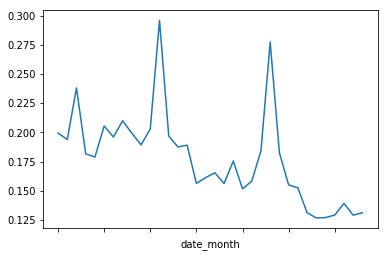

In [57]:
df_tmp = pd.DataFrame(data=[df_months.mean(), df_months.std()], index=['mean', 'std']).transpose()
df_tmp = df_tmp.merge(df_date, left_index=True, right_index=True)
print(df_tmp.tail(13))
df_tmp.set_index('date_month')['mean'].plot()

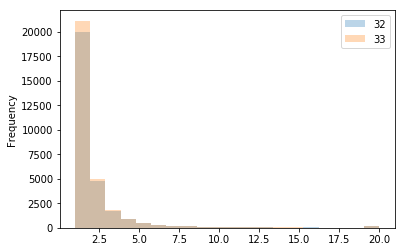

In [56]:
s = df_months[[32, 33]]
s[s>0].plot.hist(bins=20, alpha=0.3)

# check shops

In [24]:
check_shop_ids = [34, 36, 39, 48, 49]

for shid in check_shop_ids:
    print(shid, df_train_piv[df_train_piv['shop_id'] == shid].shape, df_test[df_test['shop_id'] == shid].shape)


34 (5686, 38) (5100, 5)
36 (5106, 38) (5100, 5)
39 (6924, 38) (5100, 5)
48 (6701, 38) (5100, 5)
49 (6728, 38) (5100, 5)


In [25]:
df_shop_months = df_train_piv.groupby('shop_id').sum()
df_shop_months.drop(['item_id', 'item_category_id', 'bigcat'], axis=1, inplace=True)

df_shop_months.iloc[:, 20:]

,20,21,22,23,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,
2,827.0,878.0,985.0,1743.0,945.0,881.0,746.0,685.0,713.0,773.0,762.0,942.0,802.000000,717.0
3,821.0,718.0,1000.0,1217.0,955.0,737.0,724.0,679.0,699.0,658.0,532.0,637.0,617.000000,613.0
4,981.0,1076.0,1181.0,1835.0,1098.0,922.0,903.0,778.0,797.0,759.0,812.0,868.0,687.000000,748.0
5,1201.0,1105.0,1301.0,1946.0,1290.0,1070.0,1094.0,875.0,950.0,934.0,956.0,1246.0,1028.000000,1029.0
6,2292.0,2297.0,2620.0,3722.0,2224.0,2195.0,1904.0,1582.0,1430.0,1497.0,1440.0,1522.0,1565.000000,1676.0
7,1543.0,1515.0,1838.0,2949.0,1928.0,1701.0,1351.0,1166.0,1085.0,1196.0,1274.0,1376.0,1227.000000,1169.0
10,671.0,589.0,717.0,1010.0,583.0,0.0,537.0,501.0,429.0,441.0,434.0,442.0,502.000000,428.0
12,1116.0,1222.0,1742.0,2613.0,1444.0,1431.0,1275.0,1388.0,1015.0,1354.0,1108.0,1268.0,1611.000000,1268.0
14,1109.0,1079.0,1326.0,1681.0,1131.0,941.0,937.0,775.0,788.0,937.0,897.0,1030.0,986.000000,941.0


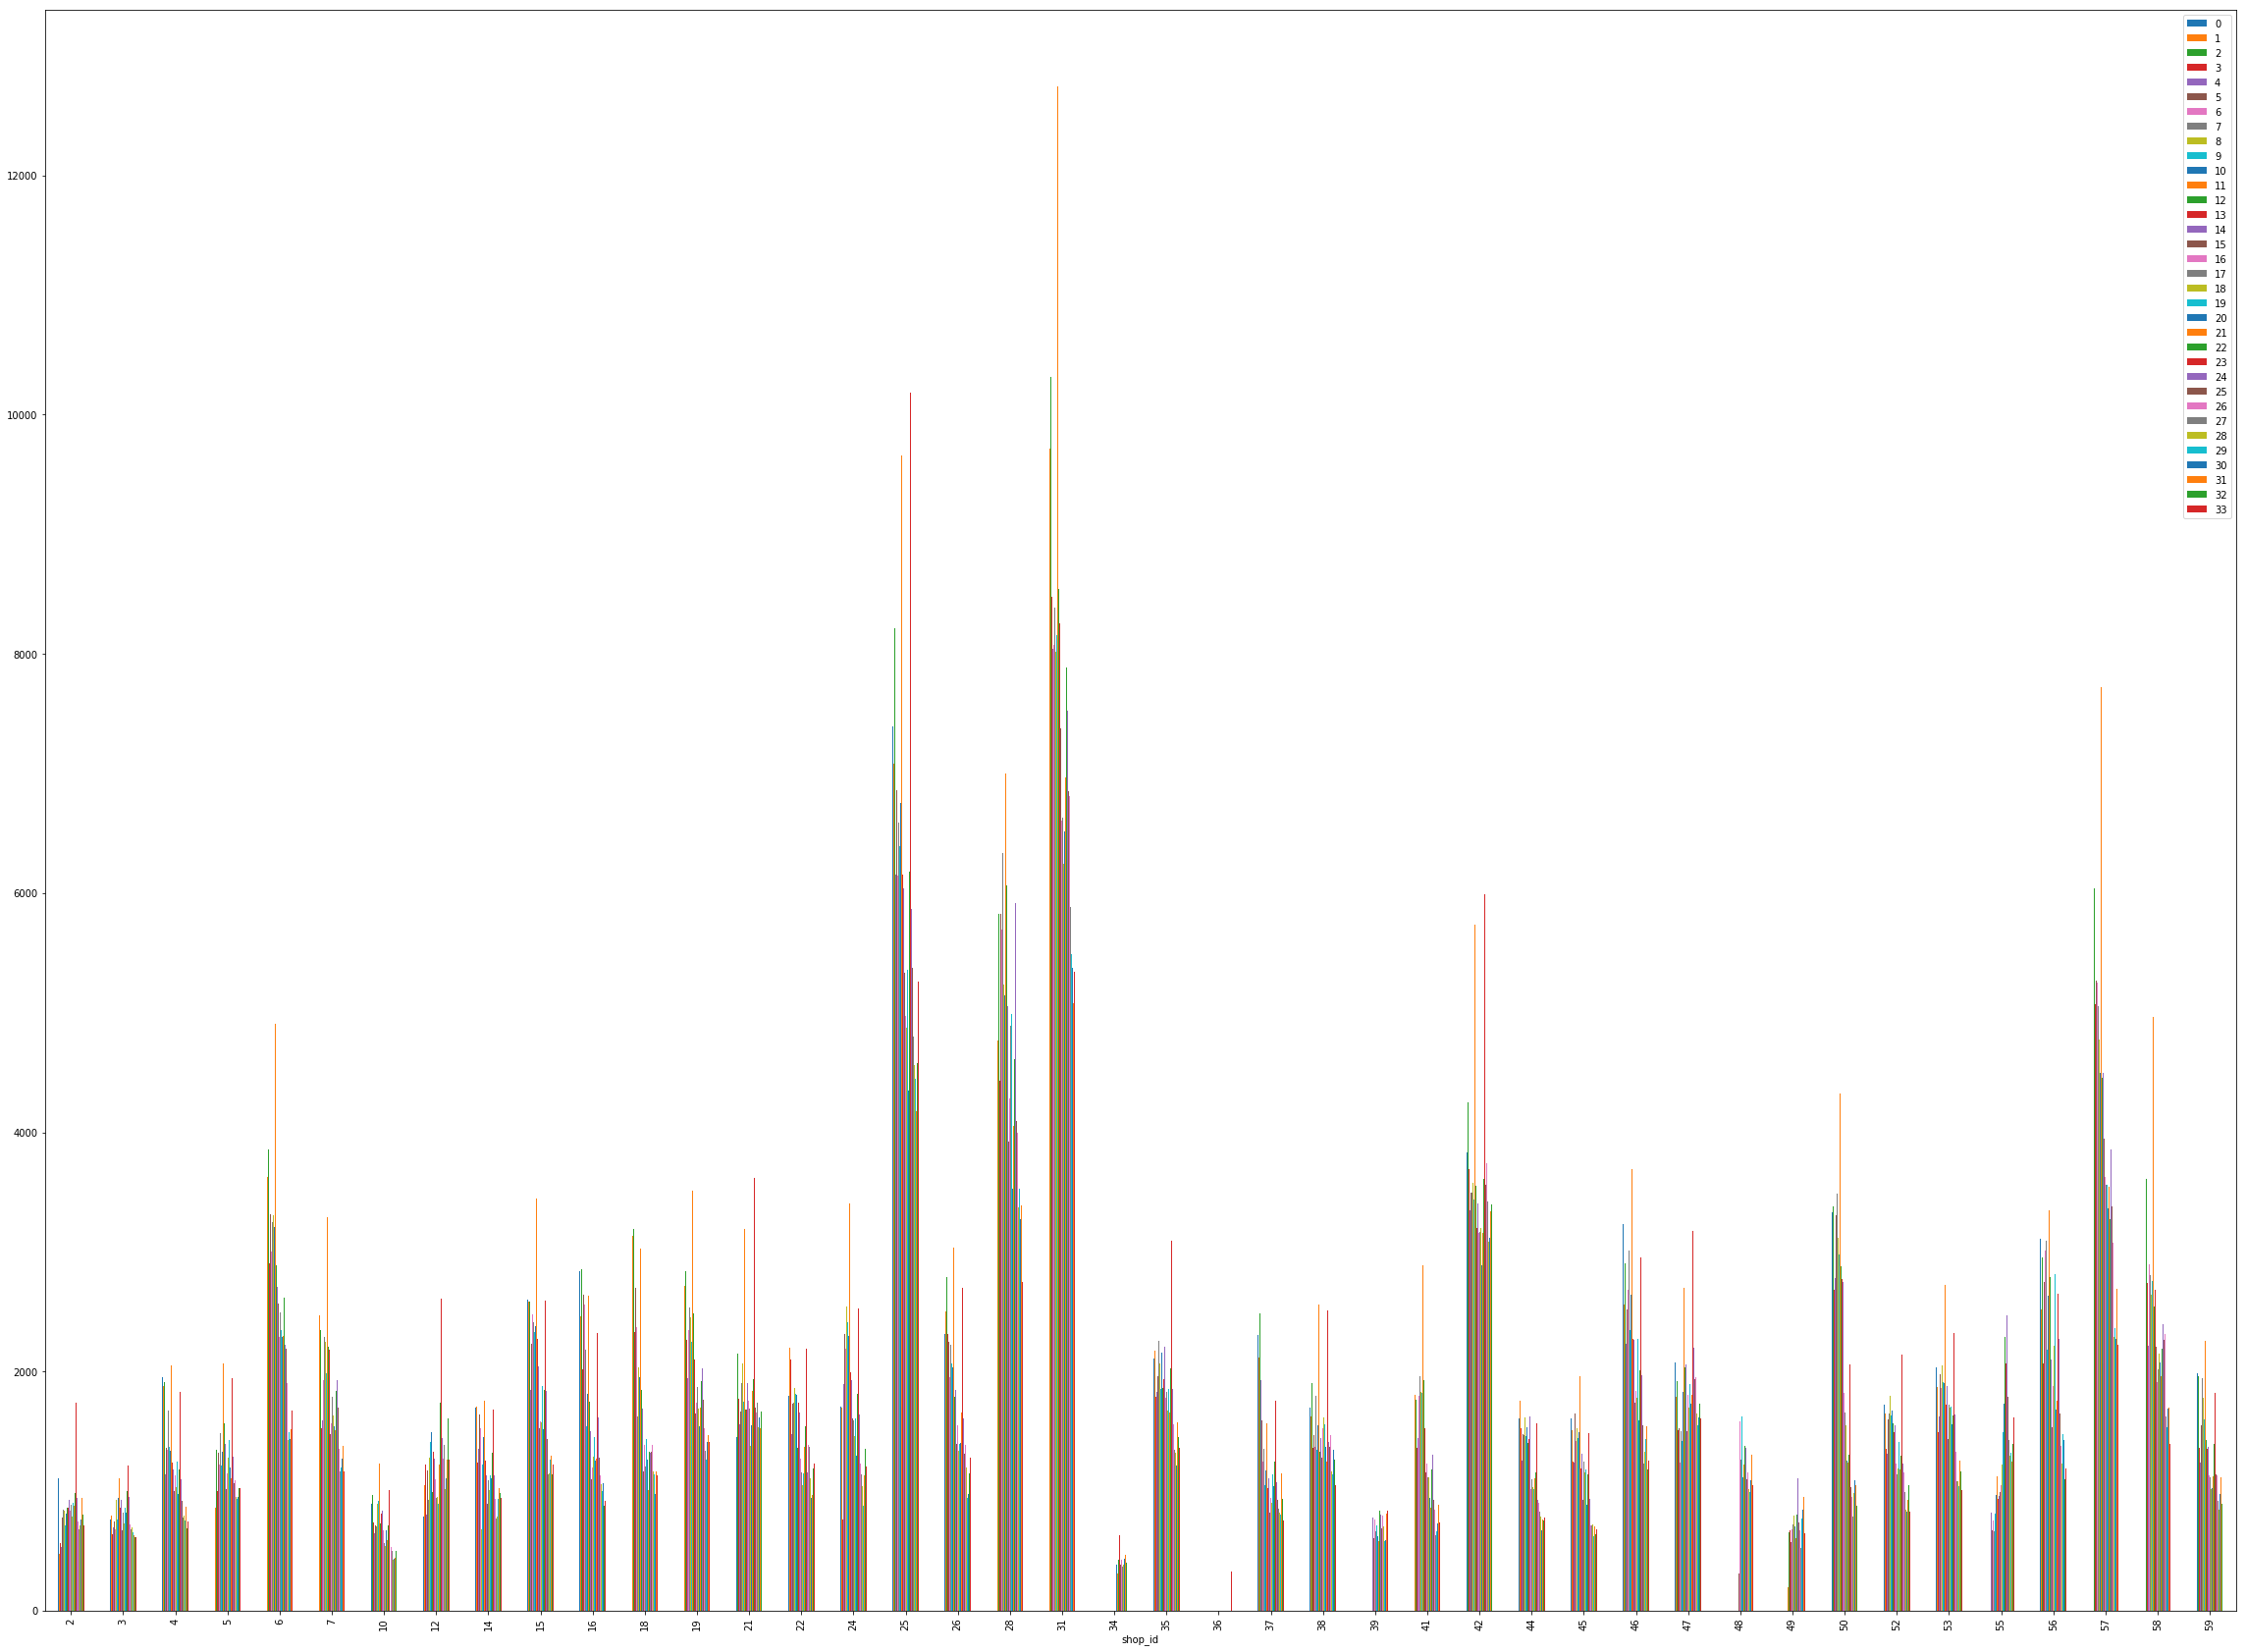

In [21]:
df_shop_months.plot.bar(figsize=(40, 30))

# Preprocess categories

In [26]:
df_cats = df_train_piv.iloc[:, :4]
df_cats.nunique()

shop_id                42
item_id             20813
item_category_id       62
bigcat                 16
dtype: int64

In [27]:
df_cats.loc[:, 'shop_item'] = df_cats['shop_id'].astype(str) + '_' + df_cats['item_id'].astype(str)
df_cats.loc[:, 'shop_category'] = df_cats['shop_id'].astype(str) + '_' + df_cats['item_category_id'].astype(str)
df_cats.loc[:, 'shop_bigcat'] = df_cats['shop_id'].astype(str) + '_' + df_cats['bigcat'].astype(str)
df_cats.head()

,shop_id,item_id,item_category_id,bigcat,shop_item,shop_category,shop_bigcat
0,2,27,19,5,2_27,2_19,2_5
1,2,30,40,7,2_30,2_40,2_7
2,2,31,37,7,2_31,2_37,2_7
3,2,32,40,7,2_32,2_40,2_7
4,2,33,37,7,2_33,2_37,2_7


In [28]:
from sklearn.preprocessing import OneHotEncoder
onehot_enc = OneHotEncoder()
# onehot_cols = df_cats.columns[df_cats.columns != 'item_id'].tolist()
onehot_cols = ['shop_id', 'item_category_id']
X_onehot = onehot_enc.fit_transform(df_cats.loc[:, onehot_cols])

In [29]:
label_cols = list(set(df_cats.columns.tolist()) - set(onehot_cols))
df_cats = df_cats.astype('category').astype(np.int32)
df_labels = df_cats[label_cols]
X_label = sparse.csr_matrix(df_labels.values)

In [30]:
def expanding_mean_encoding(df, group_cols, y_target):
    df.loc[:, '_y_target'] = y_target
    cumsum = df.groupby(group_cols)['_y_target'].cumsum() - df['_y_target']
    cumcnt = df.groupby(group_cols)['_y_target'].cumcount()
    return cumsum / cumcnt

In [31]:
def mean_encoding(df, group_cols, y_target):
    df.loc[:, '_y_target'] = y_target
    map_dict = df.groupby(group_cols)['_y_target'].mean().to_dict()
    return df[group_cols].map(map_dict).values

In [60]:
label_cols = ['item_id']
# map_dict = mean_encoding(df_train_piv.loc[:, label_cols + [32]], label_cols, 32)
map_dict = expanding_mean_encoding(df_train_piv.loc[:, label_cols + [32]], label_cols, 32)

X_label = sparse.csr_matrix(df_train_piv[label_cols[0]].map(map_dict))
X_label = X_label.transpose()

<class 'pandas.core.series.Series'>


# xgbost

In [32]:
def period_column_feats(X, period=12):
    n_col = X.shape[1]
    feats = []

    for i in range(12):
        cols = [i]
        j = 1
        while i + j * period < n_col:
            cols.append(i + j * period)
            j += 1
        feats.extend([X[:, cols].mean(axis=1), X[:, cols].max(axis=1), X[:, cols].min(
            axis=1), X[:, cols].std(axis=1), np.median(X[:, cols], axis=1)])
    return np.column_stack(feats)


def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def addtion_num_cols(X):
    return np.column_stack(
            (np.mean(X, axis=1),
             np.mean(X[:, -3:], axis=1), 
             np.mean(X[:, -6:], axis=1), 
             np.mean(X[:, -12:], axis=1),
             np.std(X, axis=1),
             np.std(X[:, -3:], axis=1), 
             np.std(X[:, -6:], axis=1), 
             np.std(X[:, -12:], axis=1),
#              np.apply_along_axis(running_mean, 1, X, N=3),
#              np.apply_along_axis(running_mean, 1, X, N=6),
            ))

In [33]:
def num_cols(X):
    X_diff = np.diff(X, axis=1)
    X_period = period_column_feats(X)
    
    X_ad = addtion_num_cols(X)
    X_diff_ad = addtion_num_cols(X_diff)
    X_period_ad = addtion_num_cols(X_period)
    
    return sparse.csr_matrix(np.column_stack((
        X,
        X_diff,
        X_period,
        X_ad,
        X_diff_ad,
        X_period_ad
    )))    

In [34]:
def predict_func(xm, bsts):
    preds = []
    for bst in bsts:
        preds.append(bst.predict(xm, ntree_limit=bst.best_ntree_limit))
#         preds.append(bst.predict(xm))
    return np.mean(np.column_stack(preds), axis=1)

In [35]:
def apply_mean_encode(X, enc_cols, n=2, df_cats=df_cats):
    X_mean_code = np.empty((X.shape[0], len(enc_cols)*n))
#     X_mean_code_diff = np.empty((X.shape[0], len(enc_cols)*(n-1)))
    for i, enc_col in enumerate(enc_cols):
        for j in range(n):
            X_mean_code[:, i*n + j] = mean_encoding(df_cats, enc_col, X[:, -(j+1)])
#             if j > 0:
#                 X_mean_code_diff[:, i*(n-1) + (j-1)] = X_mean_code[:, i*n + j] - X_mean_code[:, i*n + j-1]          
#     return np.column_stack((X_mean_code, X_mean_code_diff))
    return X_mean_code

In [38]:
df_months.iloc[:, [-12]]

,22
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [138]:
# training_flag = True
training_flag = False
n_months = 22


# enc_cols = ['shop_id']
enc_cols = ['shop_id', 'shop_category', 'item_id', 'bigcat']

if training_flag:
    train_cols = [-12,  -1]
#     train_cols = [-6, -5, -4, -3, -2, -1]
else:
    train_cols = [-12,-2, -1]
    

for train_col in train_cols:
    X_train = df_months.iloc[:, train_col - n_months:train_col].values
    y_train = df_months.iloc[:, train_col].values
    

#     X_train = sparse.hstack((X_price, X_onehot, X_label, apply_mean_encode(X_train, enc_cols), num_cols(X_train)))
    
    X_train = sparse.hstack((X_onehot, X_label, apply_mean_encode(X_train, enc_cols), num_cols(X_train)))
#     y_train = df_months.iloc[:, train_col].values - df_months.iloc[:, train_col-1].values

    if train_col == train_cols[0]:
        X_train_cum, y_train_cum = X_train, y_train
    else:
        X_train_cum = sparse.vstack((X_train_cum, X_train), format='csr')
        y_train_cum = np.concatenate((y_train_cum, y_train))

print(X_train_cum.shape)

(1306281, 244)


In [139]:
gc.collect()

111

In [140]:
print(X_onehot.shape[1])
print(X_onehot.shape[1] + X_label.shape[1])
# X_onehot.shape[1] + X_label.shape[1] + X_train_mean_code.shape[1]

104
109


In [141]:
if training_flag:
    val_col = train_cols[-1] + 1
else:
    val_col = train_cols[-1]

X_val = df_months.iloc[:, val_col - n_months:val_col].values
y_val = df_months.iloc[:, val_col].values
X_val = sparse.hstack((X_onehot, X_label, apply_mean_encode(X_val, enc_cols), num_cols(X_val)))
# y_val = df_months.iloc[:, val_col].values - df_months.iloc[:, val_col-1].values

In [142]:
last_col = -1
X_last = df_months.iloc[:, last_col - n_months:last_col].values

    
X_last = sparse.hstack((X_onehot, X_label, apply_mean_encode(X_last, enc_cols), num_cols(X_last)))
y_last = df_months.iloc[:, last_col].values

xgblast = xgb.DMatrix(X_last)

In [158]:
bsts = []
df_limit = pd.DataFrame(columns=['i', 'limit'])

param = {'max_depth': 5,
         'subsample': 0.8,
         'colsample_bytree': 0.8,
         #          'min_child_weight':0.5,
         'eta': 0.2,
#          'seed': 1,
         'eval_metric': 'rmse'}


# xgbtrain = xgb.DMatrix(X_train_cum, y_train_cum)
# xgbval = xgb.DMatrix(X_val, y_val)


n_trees = 1
xgbval = xgb.DMatrix(X_val, y_val)
tree_limit_choices = [25, 30, 35, 40]

last_rmses = []

for i in range(n_trees):

#     np.random.seed(i)
#     idxes = np.random.choice(X_train_cum.shape[0], X_train_cum.shape[0])
#     X_train_sample = X_train_cum[idxes]
#     y_train_sample = y_train_cum[idxes]
#     xgbtrain = xgb.DMatrix(X_train_sample, y_train_sample)
#     bst = xgb.train(param, xgbtrain, num_boost_round=np.random.choice(tree_limit_choices))

    xgbtrain = xgb.DMatrix(X_train_cum, y_train_cum)
    watchlist = [(xgbtrain, 'train'), (xgbval, 'val')]
    bst = xgb.train(param, xgbtrain, num_boost_round=20, evals=watchlist, early_stopping_rounds=10, verbose_eval=1)

    bsts.append(bst)
    bst.save_model('models/{}.model'.format(i))
    df_limit.loc[df_limit.shape[0]] = [i, bst.best_ntree_limit]
    df_limit.to_csv('models/df_limit.csv', index=False)

    preds_val = predict_func(xgbval, bsts)
    preds_last = predict_func(xgblast, bsts)
    print(i, bst.best_ntree_limit, np.sqrt(mean_squared_error(
        y_val, preds_val)), np.sqrt(mean_squared_error(y_last, preds_last)))
    last_rmses.append(np.sqrt(mean_squared_error(y_last, preds_last)))
    gc.collect()

del xgbval
gc.collect()

[0]	train-rmse:0.871625	val-rmse:0.785909
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.818024	val-rmse:0.730039
[2]	train-rmse:0.780531	val-rmse:0.691299
[3]	train-rmse:0.754645	val-rmse:0.665309
[4]	train-rmse:0.736179	val-rmse:0.646962
[5]	train-rmse:0.723252	val-rmse:0.634204
[6]	train-rmse:0.714069	val-rmse:0.625581
[7]	train-rmse:0.707009	val-rmse:0.618293
[8]	train-rmse:0.702444	val-rmse:0.613765
[9]	train-rmse:0.698227	val-rmse:0.608813
[10]	train-rmse:0.694849	val-rmse:0.60443
[11]	train-rmse:0.690979	val-rmse:0.597301
[12]	train-rmse:0.689092	val-rmse:0.595728
[13]	train-rmse:0.687029	val-rmse:0.593422
[14]	train-rmse:0.68419	val-rmse:0.587357
[15]	train-rmse:0.683262	val-rmse:0.586614
[16]	train-rmse:0.681998	val-rmse:0.585064
[17]	train-rmse:0.681033	val-rmse:0.58392
[18]	train-rmse:0.680171	val-rmse:0.583213
[19]	train-rmse:0.679116	val-rmse:0.581481
0 20 0.58148

0

In [159]:
preds_last = predict_func(xgblast, bsts)
print(i, bst.best_ntree_limit, np.sqrt(mean_squared_error(
    y_val, preds_val)), np.sqrt(mean_squared_error(y_last, preds_last)))

0 20 0.5814813 0.5814813


In [160]:
# bsts = []
# for i in range(n_trees):
#     bsts.append(xgb.Booster(model_file='models/{}.model'.format(i)))

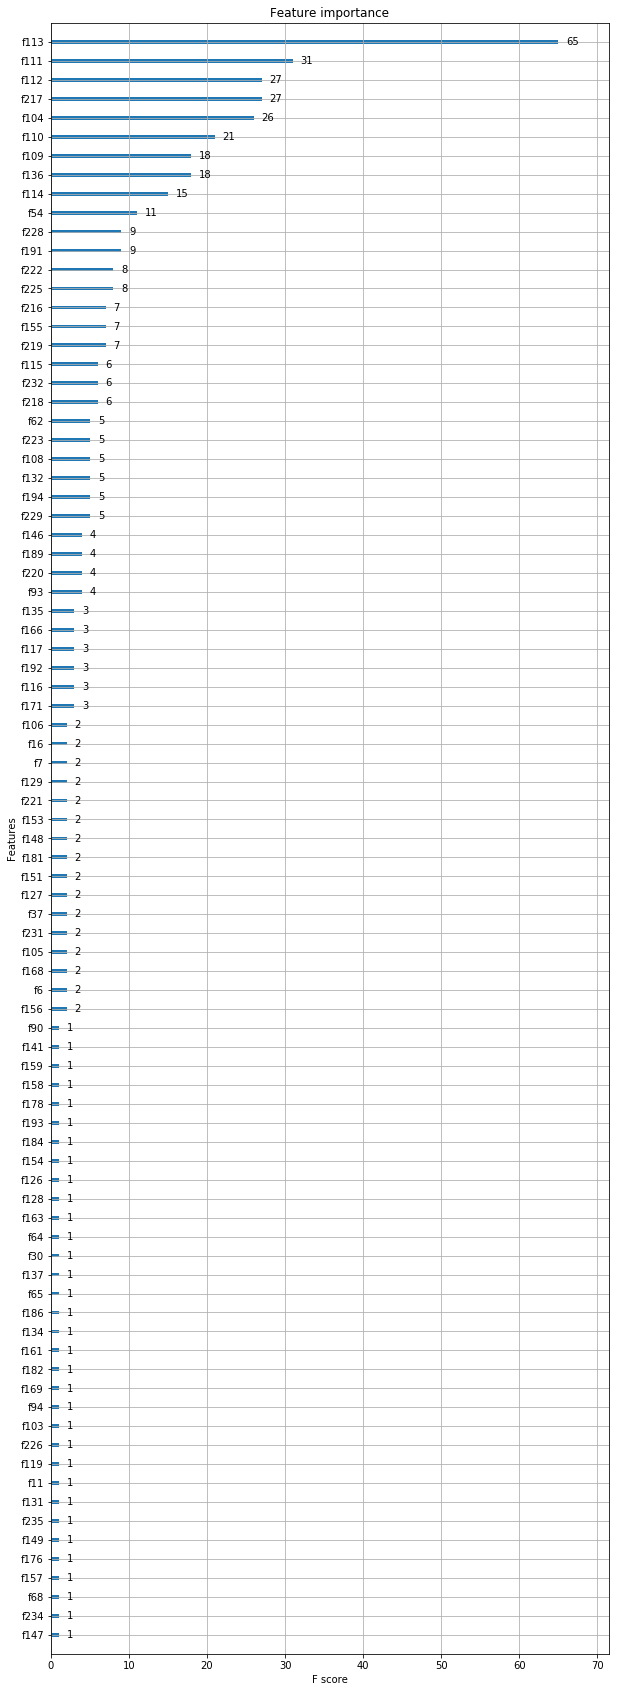

In [47]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

my_plot_importance(bst, figsize=(10, 30))

In [161]:
df_test = df_test.merge(df_train_piv[df_train_piv.columns[~df_train_piv.columns.isin(['item_category_id', 'bigcat'])]], how = "left", on = ["shop_id", "item_id"])
df_test[['bigcat']] = number.fit_transform(df_test.bigcat)
df_test.iloc[:, -34:] = df_test.iloc[:, -34:].fillna(0)

df_test_cats = df_test[['ID', 'shop_id', 'item_id']].merge(df_cats, how='left', on=['shop_id', 'item_id'])
df_test_cats.head()

X_test_label = sparse.csr_matrix(df_test_cats[label_cols].values)

X_test_onehot = onehot_enc.transform(df_test_cats.loc[:, onehot_cols])
X_test = df_test.iloc[:, -n_months:].values

X_test = sparse.hstack((X_test_onehot, X_test_label, apply_mean_encode(X_test, enc_cols, df_cats=df_test_cats), num_cols(X_test)))

xgbtest = xgb.DMatrix(X_test)

In [162]:
preds = predict_func(xgbtest, bsts)
preds = np.clip(preds, 0, 20)

print(np.mean(preds))
np.std(preds)

0.29856646


0.78276765

In [164]:
# Normalize prediction to [0-20]
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds-0.01})
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

sub_df.head()

,ID,item_cnt_month
0,0,0.878086
1,1,0.052119
2,2,0.884921
3,3,0.424543
4,4,1.149394


# Random Forest

In [25]:
X = df_train_piv.iloc[:,  (df_train_piv.columns != 33)].values
y = df_train_piv.iloc[:, df_train_piv.columns == 33].values.ravel()
shopids = df_train_piv['shop_id'].values

In [41]:


# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
# train_index, val_index = next(skf.split(X, shopids))
# X_train, y_train = X[train_index], y[train_index]
# X_val, y_val = X[val_index], y[val_index]



# # X, y = sklearn.datasets.load_digits(10,True)
# X_train, X_val, y_train, y_val = train_test_split(X, y)

In [47]:
# from sklearn.ensemble import RandomForestRegressor

# n_estimators = 100
# rf = RandomForestRegressor(warm_start=True, criterion='mse', n_jobs=-1)

# train_scores = []
# val_scores = []
# for i in range(1, n_estimators + 1):
#     rf.set_params(n_estimators=i)
#     rf.fit(X_train, y_train)
#     train_pred = rf.predict(X_train)
#     val_pred = rf.predict(X_val)
#     train_score = np.sqrt(mean_squared_error(train_pred, y_train))
#     val_score = np.sqrt(mean_squared_error(val_pred, y_val))                    
#     print(i, train_score, val_score)

In [44]:
df_test = df_test_.copy()
df_test['shop_id']= df_test_.shop_id.astype('str')
df_test['item_id']= df_test_.item_id.astype('str')

df_test = df_test.merge(df_train_piv, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
df_test.head()

,ID,shop_id,item_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
d = dict(zip(df_test.columns[4:],list(np.array(list(df_test.columns[4:])) - 1)))
df_test  = df_test.rename(d, axis = 1)
df_test.head()

,ID,shop_id,item_id,bigcat,-1,0,1,2,3,4,...,23,24,25,26,27,28,29,30,31,32
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
preds = rf.predict(df_test.iloc[:, (df_test.columns != 'ID') & (df_test.columns != -1)].values)

# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds })
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

In [ ]:
kaggle competitions submit -c competitive-data-science-final-project -f submission.csv -m "Message"